In [1]:
import os
import torch
from pathlib import Path
import mediapy
import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List, Dict, Any, Union
# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

import gpudrive
from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Increase the resolution of the figure
plt.rcParams['figure.dpi'] = 100  # Higher DPI for better resolution


# Use a more readable font
plt.rcParams['font.size'] = 12  # Increase font size
plt.rcParams['font.family'] = 'sans-serif'  # Use a clean font like Arial
plt.rcParams['axes.titlesize'] = 14  # Larger title size
plt.rcParams['axes.labelsize'] = 12  # Larger axis label size


In [2]:
DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 32
NUM_ENVS = 10

# Configs
render_config = RenderConfig(draw_obj_idx=True)
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Questions:

- What is a good balance between the number of road points and the road reduction threshold?

In [3]:
env_config.polyline_reduction_threshold = 0.01
%load_ext autoreload
%autoreload 2

In [4]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    render_config=render_config,
    action_type="continuous" # "continuous" or "discrete"
)

env.reset()


--- Ratio unique scenes / number of worls = 3 / 10 ---



tensor([[[0.0868, 0.1541, 0.2051,  ..., 0.0000, 0.0000, 0.0000],
         [0.0627, 0.1494, 0.2001,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1866, 0.2441,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1219, 0.1577, 0.2127,  ..., 0.0000, 0.0000, 0.0000],
         [0.1470, 0.1483, 0.1968,  ..., 0.0000, 0.0000, 0.0000],
         [0.0971, 0.1881, 0.2325,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.1552, 0.2115,  ..., 0.0000, 0.0000, 0.0000],
         [0.1203, 0.1571, 0.2115,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1529, 0.2014,  ..., 0.0000, 0.0000, 0.

### Plot simulator state

In [5]:
from pygpudrive.datatypes.roadgraph import GlobalRoadGraphPoints
from pygpudrive.datatypes.control import ControlMasks
import matplotlib.pyplot as plt
import numpy as np
from pygpudrive.datatypes.observation import GlobalEgoState

# Get global road graph (note: only needs to be done once)
global_rg = GlobalRoadGraphPoints.from_tensor(
    roadgraph_tensor=env.sim.map_observation_tensor(),
    backend='torch',
    device='cpu',
)

# Get control type tensor
types = ControlMasks.from_tensor(
    tensor=env.sim.response_type_tensor(),
    backend='torch',
    device='cpu',
)

# Get global agent state
global_agent_state = GlobalEgoState.from_tensor(
    env.sim.absolute_self_observation_tensor(),
    backend='torch',
    device='cpu',
)

global_rg.x.shape

env_idx = 6

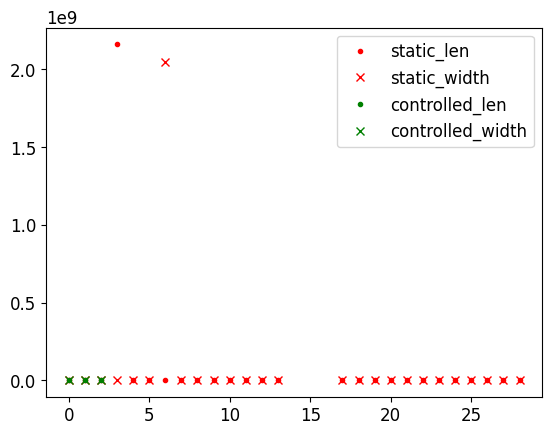

In [6]:
plt.plot(global_agent_state.vehicle_length[env_idx][types.static[env_idx]], 'r.', label='static_len')
plt.plot(global_agent_state.vehicle_width[env_idx][types.static[env_idx]], 'rx', label='static_width')   
plt.plot(global_agent_state.vehicle_length[env_idx][types.controlled[env_idx]], 'g.', label='controlled_len')
plt.plot(global_agent_state.vehicle_width[env_idx][types.controlled[env_idx]], 'gx', label='controlled_width')   
plt.legend();

In [7]:
is_offroad = env.sim.info_tensor().to_torch()[env_idx, :, 0] == 1
is_collided = env.sim.info_tensor().to_torch()[env_idx, :, 1:3].sum(axis=1) == 1
is_ok = ~is_offroad & ~is_collided

is_offroad.shape, is_collided.shape, is_ok.shape

(torch.Size([32]), torch.Size([32]), torch.Size([32]))

In [8]:
is_ok & types.controlled[env_idx]

tensor([ True,  True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

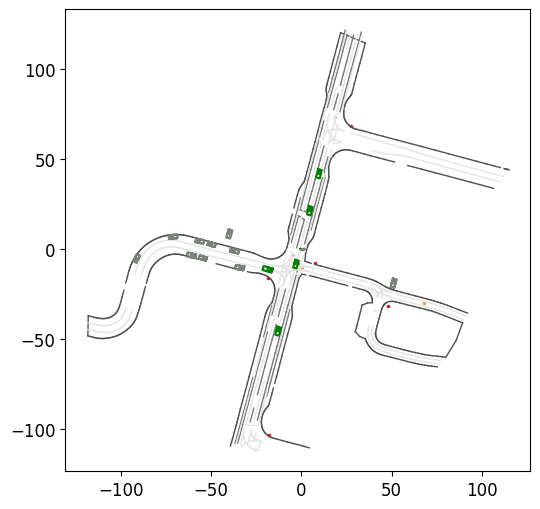

In [15]:
#fig, ax = plt.subplots(figsize=(7, 7))

env.vis.plot_simulator_state(
    env_idx=5,
)

In [13]:
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
    device="cpu"
)

local_roadgraph

LocalRoadGraphPoints()

In [23]:
import gpudrive

int(gpudrive.EntityType._None), int(gpudrive.EntityType.RoadEdge), 

(0, 1)

In [24]:
env.cont_agent_mask

tensor([[ True,  True, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False]])

In [25]:
local_roadgraph.type[env.cont_agent_mask].shape

torch.Size([3, 256])

In [26]:
local_roadgraph.type[env.cont_agent_mask][0, :]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [27]:
padding_perc = (local_roadgraph.type[env.cont_agent_mask] == 0).sum()/local_roadgraph.type[env.cont_agent_mask].numel()

padding_perc

tensor(0.)

In [28]:
local_roadgraph.x.min(), local_roadgraph.x.max()

(tensor(-99.6710), tensor(99.6373))

In [29]:
local_roadgraph.y.min(), local_roadgraph.y.max()

(tensor(-97.7108), tensor(97.2689))

In [30]:
local_roadgraph.y.min(), local_roadgraph.y.max()

(tensor(-97.7108), tensor(97.2689))

In [31]:
local_roadgraph.segment_height.max(), local_roadgraph.segment_height.min()

(tensor(0.1000), tensor(0.))

In [32]:
local_roadgraph.segment_width.max(), local_roadgraph.segment_width.min()

(tensor(0.1000), tensor(0.))

In [33]:
local_roadgraph.segment_length.max(), local_roadgraph.segment_length.min()

(tensor(7.8055), tensor(0.))

### Check agent observation

In [34]:
%load_ext autoreload
%autoreload 2

from pygpudrive.visualize.core import plot_agent_observation
from pygpudrive.datatypes.observation import (
    LocalEgoState,
    PartnerObs,
    LidarObs,
)
from pygpudrive.datatypes.trajectory import LogTrajectory
from pygpudrive.datatypes.roadgraph import LocalRoadGraphPoints


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
ego_state = LocalEgoState.from_tensor(
    self_obs_tensor=env.sim.self_observation_tensor(),
    backend="torch",
    device="cpu",
)

local_roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend="torch",
    device="cpu",
)

partner_obs = PartnerObs.from_tensor(
    partner_obs_tensor=env.sim.partner_observations_tensor(),
    backend="torch",
    device="cpu"
)

partner_obs.rel_pos_x.shape

torch.Size([1, 32, 31, 1])

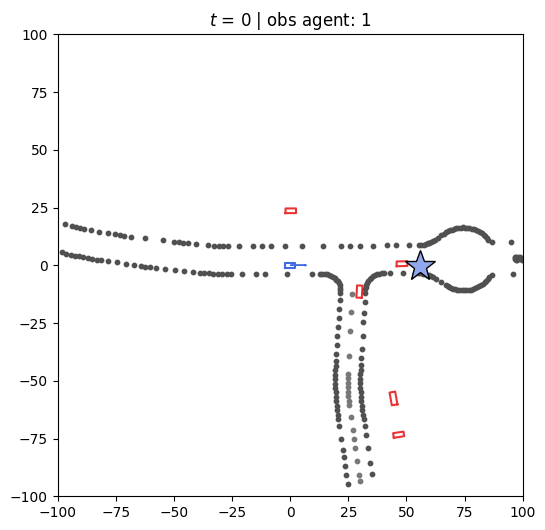

: 

In [36]:
fig, ax = plot_agent_observation(
    env_idx=0,
    agent_idx=1,
    observation_roadgraph=local_roadgraph,
    observation_ego=ego_state,
    observation_partner=partner_obs,
    time_step=0,
);

### Check LiDAR observations

- Normalize 
- Check obs dim

In [46]:
env.reset();

In [42]:
lidar = env.sim.lidar_tensor().to_torch()

lidar.shape

torch.Size([1, 32, 3, 50, 4])

In [43]:
lidar[env.cont_agent_mask].shape

torch.Size([3, 3, 50, 4])

In [45]:
lidar[env.cont_agent_mask].max(), lidar[env.cont_agent_mask].min()

(tensor(3.2548e+33), tensor(-2.5835e+14))

In [13]:
lidar = LidarObs.from_tensor(
    lidar_tensor=env.sim.lidar_tensor(),
    backend='torch'
)

In [14]:
lidar.agent_samples.shape

torch.Size([1, 32, 50, 4])

In [15]:
lidar.road_edge_samples.shape

torch.Size([1, 32, 50, 4])

In [ ]:
lidar.road_line_samples.shape

torch.Size([1, 32, 50, 4])

In [26]:
lidar_all = torch.cat(
    [
        lidar.agent_samples,
        lidar.road_edge_samples,
        lidar.road_line_samples,
    ],
    dim=-1,
).flatten(start_dim=2)

lidar_all[env.cont_agent_mask, :].shape

torch.Size([3, 600])

In [27]:
lidar_all.shape

torch.Size([1, 32, 600])

In [29]:
lidar_all[env.cont_agent_mask, :].max(), lidar_all[env.cont_agent_mask, :].min()

(tensor(3.2548e+33), tensor(-2.5835e+14))

In [33]:
lidar.agent_samples[env.cont_agent_mask].max(), lidar.agent_samples[env.cont_agent_mask].min()


(tensor(3.2548e+33), tensor(-2.5835e+14))

In [35]:
lidar.road_edge_samples[env.cont_agent_mask].max(), lidar.road_edge_samples[env.cont_agent_mask].min()

(tensor(4.8408e+30), tensor(-2.5835e+14))

In [31]:
lidar.road_line_samples.max(), lidar.road_line_samples.min()


(tensor(7.2335e+10), tensor(-2.5835e+14))

In [32]:
lidar.shape

torch.Size([1, 32, 3, 50, 4])

In [24]:
lidar.agent_samples

tensor([[[[ 7.2349e+10,  4.5811e-41,  7.2349e+10,  4.5811e-41],
          [-2.5771e+14,  3.0662e-41, -2.5771e+14,  3.0662e-41],
          [-2.5835e+14,  3.0662e-41, -2.5771e+14,  3.0662e-41],
          ...,
          [ 4.3409e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  4.6243e-44,  0.0000e+00]],

         [[-2.5774e+14,  3.0662e-41,  0.0000e+00,  0.0000e+00],
          [ 6.7359e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00],
          [-2.5471e+14,  3.0662e-41,  0.0000e+00,  0.0000e+00],
          ...,
          [ 4.3051e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 6.7466e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  4.6243e-44,  0.0000e+00],
          [-2.2988e+13,  3.0662e-41, -2.5475e+14,  3.0662e-41],
          [ 6.7697e-40,  0.0000e+00,  1.1210e-43,  0.0000e+00],
      